In [127]:
import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap

from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.ndimage import gaussian_filter


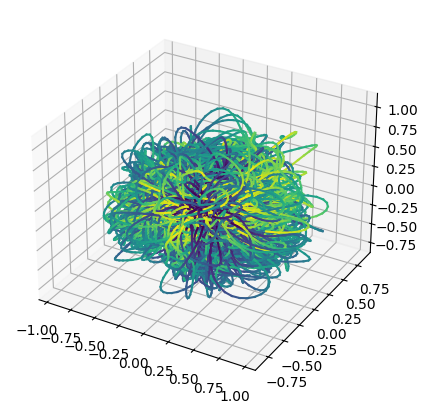

In [128]:
Y_pca = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_spikes/Y_pca_3d_spikes.npy')
plot_3D(Y_pca)

In [113]:
def plot_1D(X):
    K, _, T = X.shape
    cmap = plt.cm.viridis  
    fig, ax = plt.subplots() 

    for k in range(K):
        for t in range(T - 1):
            ax.plot([t, t + 1], [X[k, 0, t], X[k, 0, t + 1]], color=cmap(t / (T - 1)))

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [121]:
def get_rotation_params(K, T, key):
    time = jnp.linspace(0, 2 *jnp.pi, T)[:, jnp.newaxis] #4
    radii = jnp.linspace(0.1, 2, K)
    radii = random.permutation(key, radii)
    phases = jnp.linspace(0, 2*jnp.pi, K)
    return time, radii, phases

def get_rotations(K, T, key):
    time, radii, phases = get_rotation_params(K, T, key)

    sine_waves = jnp.sin(time + phases) * radii
    cosine_waves = jnp.cos(time + phases) * radii
    X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)  
    return X

def get_infty_traj(K, T, key):
    time, radii, phases = get_rotation_params(K, T, key)

    r = radii * jnp.cos(time + phases)
    theta = radii * jnp.sin(time + phases)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    X = jnp.stack([x.T, y.T], axis=1)
    return X

def get_expansions(K, T, key, oneD=False):
    if oneD == False:
        initial_rates = 0.05 * (random.uniform(key, shape=(K, 2, 1)) - 0.5)
    else:
        initial_rates = 0.1 * (random.uniform(key, shape=(K, 1, 1)) - 0.5)
    time_steps = jnp.arange(T)
    X = jnp.exp(initial_rates * time_steps)
    return X

def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - x2 
    dx2_dt = x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]

def get_oscillator(K, T, seed = 42, type=van_der_pol):
    np.random.seed(seed) 
    initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(K, 2))

    t_span = (0, 10)   
    t_eval = np.linspace(t_span[0], t_span[1], T)  
    X = np.zeros((K, 2, T))
    for i, initial_conditions in enumerate(initial_conditions_list):
        solution = solve_ivp(type, t_span, initial_conditions, t_eval=t_eval)
        x1 = solution.y[0]
        x2 = solution.y[1]

        X[i, 0, :] = x1
        X[i, 1, :] = x2
    X = jnp.array(X)
    return X

def project_X(key, proj_dims = 10):
    proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
    X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
    return X

def add_isotropic_noise(X, key):
    noise = random.normal(key, (X.shape)) 
    X += 0.01 * (noise) 
    return X 

def add_random_modes(X, key1, key2, mean=0, std_dev=1):
    K, _, T = X.shape
    trajectories_1 = random.normal(key1, (K, T), dtype=X.dtype) * std_dev + mean
    trajectories_2 = random.normal(key2, (K, T), dtype=X.dtype) * std_dev + mean
    combined_trajectories = jnp.stack((trajectories_1, trajectories_2), axis=1)
    X = jnp.concatenate((X, combined_trajectories), axis=1)
    return X

def add_low_rank_noise(X, key1, key2, proj_dims = 3, sigma = 0.75 ):
    _, N, T = X.shape    
    B = random.normal(key1, (proj_dims, N))
    B, _ = jnp.linalg.qr(B)
    epsilon_t = random.normal(key2, (T, proj_dims)) * sigma

    noise = jnp.dot(epsilon_t, B) #(T, N')
    X += noise.T[None, :, :]

    return X

def apply_gaussian_smoothing(data, sigma=1, axes=-1):
    smoothed_data = gaussian_filter(np.array(data), sigma=sigma, axes=axes)
    return jnp.array(smoothed_data)



0.28777596
0.3279562


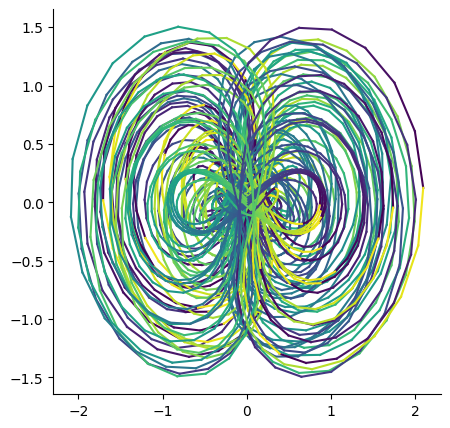

In [126]:
seed = 41
key = random.PRNGKey(seed)
key1, key2, key3 = random.split(key, 3)

K = 100
T = 50
split = 20
N = 2
d = 2 

X = get_infty_traj(K, T, key1)
X = add_low_rank_noise(X, key2, key3)
#X = center(X)

X_train=X[split:]
X_test=X[:split]
K, N, T = X_train.shape
A = jnp.swapaxes(X_train, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                              #(N, K*T)


plot_2D(center(X_train))

print(np.mean(compute_S(X_train)))
print(compute_S_all_pairs(X_test))

In [116]:
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/X_train', X_train )
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/X_test', X_test )

Iteration 0, S: 0.004459598567336798, S_ratio: 0.20157356560230255
Iteration 10, S: 0.04982271417975426, S_ratio: 0.2268012911081314
Iteration 20, S: 0.1622467190027237, S_ratio: 0.251910537481308
Iteration 30, S: 0.43524590134620667, S_ratio: 0.29935356974601746
Iteration 40, S: 0.7915688157081604, S_ratio: 0.3300328552722931
Iteration 50, S: 1.415039300918579, S_ratio: 0.36034876108169556
Iteration 60, S: 2.676252603530884, S_ratio: 0.4232913851737976
Iteration 70, S: 3.1131975650787354, S_ratio: 0.48156511783599854
Iteration 80, S: 3.9163668155670166, S_ratio: 0.5492771863937378
Iteration 90, S: 5.133819580078125, S_ratio: 0.5569358468055725
Iteration 100, S: 4.8887248039245605, S_ratio: 0.5311092138290405
Iteration 110, S: 6.5166521072387695, S_ratio: 0.6031926870346069
Iteration 120, S: 7.428553104400635, S_ratio: 0.5658490061759949
Iteration 130, S: 8.590048789978027, S_ratio: 0.6043352484703064
Iteration 140, S: 8.83365249633789, S_ratio: 0.569128692150116
Iteration 150, S: 8.94

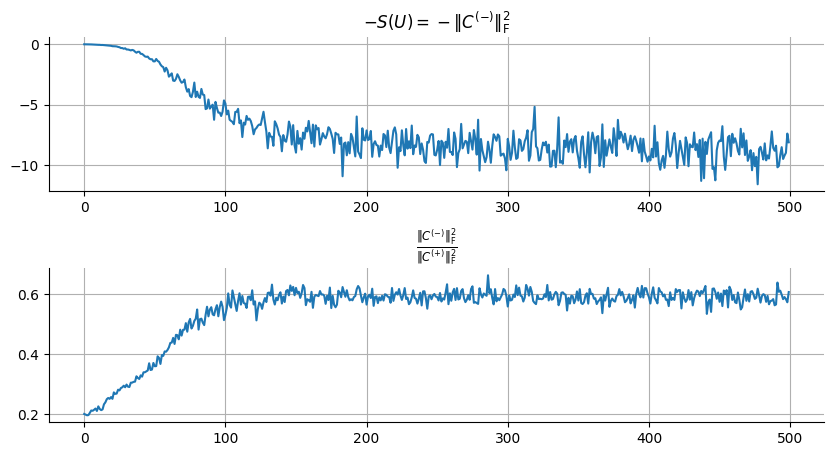

In [118]:
kernel_function=K_X_Y_rational_quadratic
d = 2

from kernel_sca_inducing_points import *
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X_train, A, iterations=500, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio )




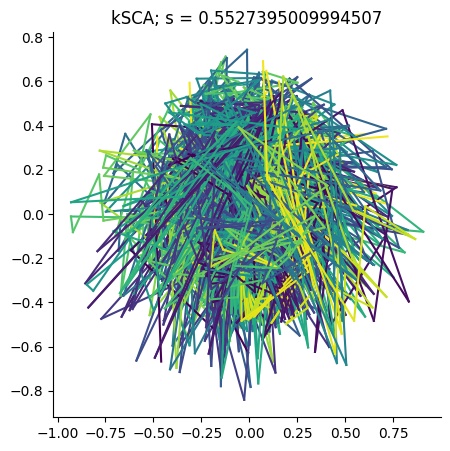

<Figure size 640x480 with 0 Axes>

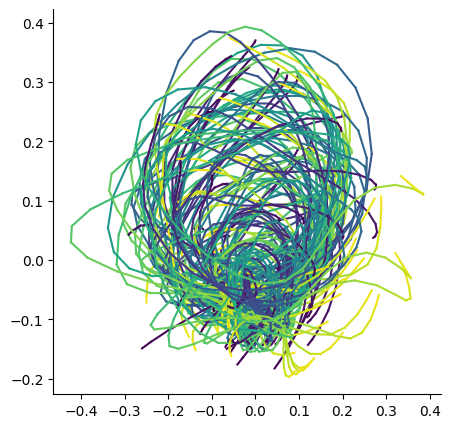

In [119]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u  = get_alpha(params, A, X_train, kernel_function, d)

K_test, _, _ = X_test.shape
X_reshaped = X_train.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

plot_2D(Y[:,:,:])
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

Y_smoothed = apply_gaussian_smoothing(Y, sigma=3)
plt.figure()
plot_2D(Y_smoothed)
# def var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u):
#     return  np.trace( K_u_u_K_u_A_alpha_H.T @ K_u_u_K_u_A_alpha_H / np.trace(K_A_u @ K_u_u @ K_A_u.T )   ) #

# print(var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u))

#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/Y_train', Y)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/ls_loss', np.array(ls_loss))
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/ls_S_ratio', np.array(ls_S_ratio))

Iteration 0, S: 41.96269989013672, S_ratio: 0.03634374216198921
Iteration 10, S: 40.53044891357422, S_ratio: 0.03583880141377449
Iteration 20, S: 17.209299087524414, S_ratio: 0.018786955624818802
Iteration 30, S: 52.533599853515625, S_ratio: 0.04452476277947426
Iteration 40, S: 12.696700096130371, S_ratio: 0.012742744758725166
Iteration 50, S: 28.529348373413086, S_ratio: 0.027667630463838577
Iteration 60, S: 26.235750198364258, S_ratio: 0.02254370041191578
Iteration 70, S: 18.360349655151367, S_ratio: 0.018907401710748672
Iteration 80, S: 23.45829963684082, S_ratio: 0.022516801953315735
Iteration 90, S: 63.92049789428711, S_ratio: 0.053016629070043564
Iteration 100, S: 17.302949905395508, S_ratio: 0.01914537511765957
Iteration 110, S: 14.276424407958984, S_ratio: 0.017825080081820488
Iteration 120, S: 35.833900451660156, S_ratio: 0.03095201589167118
Iteration 130, S: 12.869499206542969, S_ratio: 0.015173344872891903
Iteration 140, S: 18.561899185180664, S_ratio: 0.016719337552785873
I

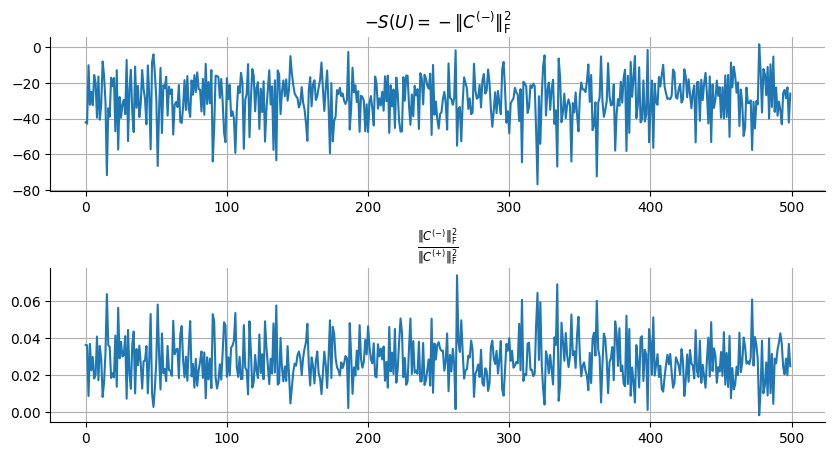

In [ ]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(center(X_train), d=d, learning_rate=0.01, iterations=500) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )


In [124]:
print(U.shape)

(2, 2)


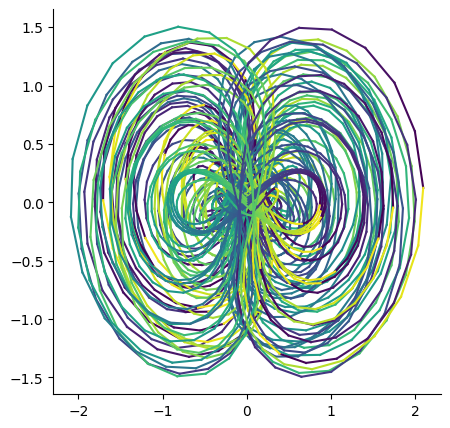

In [125]:
plot_2D(center(X_train))

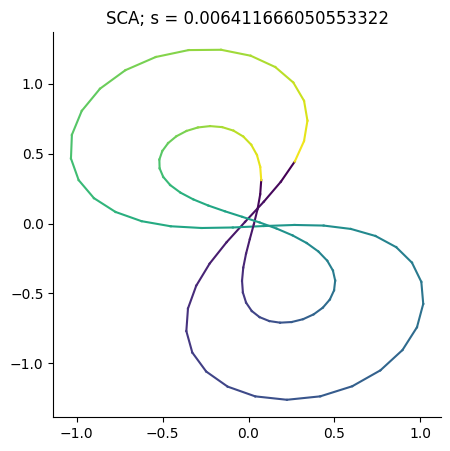

<Figure size 640x480 with 0 Axes>

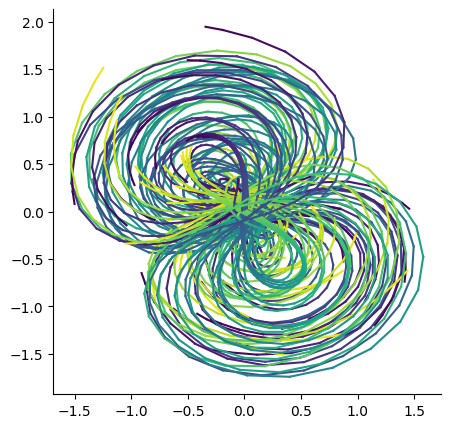

In [123]:

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, center(X_train))
plot_2D(Y[:2,:,:])
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

Y_smoothed = apply_gaussian_smoothing(Y, sigma=2)
plt.figure()
plot_2D(Y_smoothed)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/Y_test', Y)
# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/ls_loss', np.array(ls_loss))
# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/ls_S_ratio', np.array(ls_S_ratio))

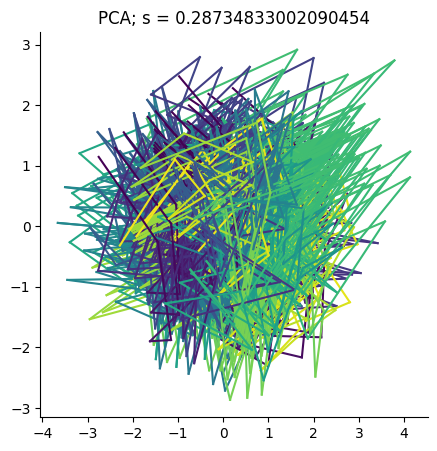

<Figure size 640x480 with 0 Axes>

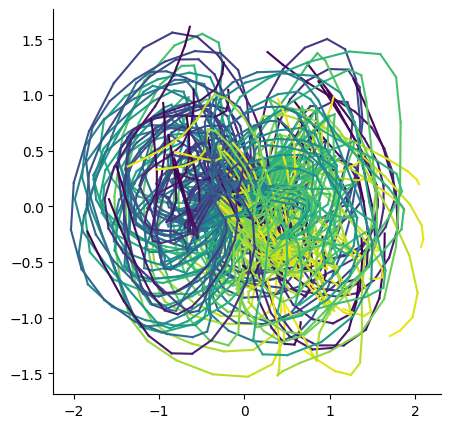

In [ ]:
""" PCA """
X_pca_train = center(X_train).swapaxes(1,2).reshape(-1, N)
X_pca_test = center(X_test).swapaxes(1,2).reshape(-1, N)

num_pcs = 2
pca = PCA(num_pcs)
Y_pca = pca.fit(X_pca_train).transform(X_pca_train)
PCs = pca.components_
Y_pca = Y_pca.reshape(-1, T, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(Y_pca)
#plt.title(f"pca {var_explained(X, PCs[:2].T):.2f}")
plt.title(f'PCA; s = {compute_S_all_pairs(jnp.array(Y_pca))}')
Y_smoothed = apply_gaussian_smoothing(Y_pca, sigma=2)
plt.figure()
plot_2D(Y_smoothed)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/pca/Y_train', Y_pca)

In [ ]:
compute_S_all_pairs(jnp.array(Y_pca))